In [2]:
import os
import sys
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
import cv2
import glob
from PIL import Image, ImageDraw
sys.path.append("..")
import assets.utils as utils
import matplotlib.pyplot as plt

#0-table, 1-chair, 2-sofa, 3-bookcase, 4-board

ModuleNotFoundError: No module named 'assets'

In [99]:
class_dict = {'table': 0, 'chair': 1, 'sofa': 2, 'bookcase': 3, 'board': 4}

def get_2d_3d_semantics_dicts(img_paths, class_dict):
    anns = utils.load_labels('/home/ubuntu/2D-3D-Semantics/assets/semantic_labels.json')
    dataset_dicts = []
    for img_path in img_paths:
        print('ex')
        record = {}
        
        #height, width = cv2.imread(img_path).shape[:2]
        record["file_name"] = img_path
        img_dir_name = os.path.dirname(img_path)
        img_file_name = os.path.basename(img_path)
        sem_file_name = "_".join(img_file_name.split('_')[:-1] + ['semantic.png'])
        sem_file_path = os.path.join(img_dir_name, '..', 'semantic', sem_file_name)
        sem_img = np.array(Image.open(sem_file_path))
        
        record["height"] = sem_img.shape[0]
        record["width"] = sem_img.shape[1]
        
        obj_colors = np.unique(sem_img.reshape(-1, sem_img.shape[2]), axis=0) 
        objs = []
        for color in obj_colors:
            index = utils.get_index(color)
            if index > len(anns):
                continue
            lbl = utils.parse_label(anns[index])
            if lbl['instance_class'] in class_dict.keys():
                print('asd')
                mask = (sem_img == color).all(-1)
                i, j = np.where(mask)
                
                obj = {
                    "bbox": [int(np.min(j)), int(np.min(i)), int(np.min(j)), int(np.max(j))],
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": class_dict[lbl['instance_class']],
                    "iscrowd": 0
                }
                objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [100]:
class_dict

{'table': 0, 'chair': 1, 'sofa': 2, 'bookcase': 3, 'board': 4}

In [101]:
obj_areas = []

In [102]:
def create_stanford_json(img_paths, class_dict, out_path):
    anns = utils.load_labels('/home/ubuntu/2D-3D-Semantics/assets/semantic_labels.json')
    dataset_dict = {}
    
    for img_path in img_paths:
        img_dict = {}
        print(img_path)
        img_dir_name = os.path.dirname(img_path)
        img_file_name = os.path.basename(img_path)
        img_dict['file_name'] = img_file_name
        
        sem_file_name = "_".join(img_file_name.split('_')[:-1] + ['semantic.png'])
        sem_file_path = os.path.join(img_dir_name, '..', 'semantic', sem_file_name)
        sem_img = np.array(Image.open(sem_file_path))
        img_dict["height"] = sem_img.shape[0]
        img_dict["width"] = sem_img.shape[1]
        
        obj_colors = np.unique(sem_img.reshape(-1, sem_img.shape[2]), axis=0) 
        img_dict['objects'] = {}
        obj_key = 0
        for color in obj_colors:
            index = utils.get_index(color)
            if index > len(anns):
                continue
            lbl = utils.parse_label(anns[index])
            if lbl['instance_class'] in class_dict.keys():
                mask = (sem_img == color).all(-1)
                i, j = np.where(mask)
                if i.shape[0] < 250:
                    continue
                obj_areas.append(i.shape[0])
                img_dict['objects'][obj_key] = {}
                img_dict['objects'][obj_key]['bbox'] = [int(np.min(j)), int(np.min(i)), int(np.max(j)), int(np.max(i))]
                img_dict['objects'][obj_key]['category_id'] = class_dict[lbl['instance_class']]
                obj_key += 1
        
        if len(img_dict['objects'].items()) == 0:
            continue

        dataset_dict[img_file_name] = img_dict 
    
    with open(out_path, 'w') as fp:
        json.dump(dataset_dict, fp)
        

In [103]:
def get_stanford_dicts(img_dir, json_path):
    with open(json_path) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for _, v in imgs_anns.items():
        record = {}

        filename = os.path.join(img_dir, v["file_name"])
        record["file_name"] = filename
        record["height"] = v["height"]
        record["width"] = v["width"]

        annos = v["objects"]
        objs = []
        for _, anno in annos.items():
            obj = {
                "bbox": anno['bbox'],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": anno['category_id'],
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [104]:
imgs = glob.glob('/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/*png')

In [106]:
len(imgs)

3704

In [115]:
imgs_train = imgs[:3300]
imgs_val = imgs[3300:3502]
imgs_test = imgs[3502:]

In [116]:
len(imgs_train), len(imgs_val), len(imgs_test)

(3300, 202, 202)

In [117]:
create_stanford_json(imgs_train, class_dict, "/home/ubuntu/2D-3D-Semantics/area_3/data/area_3_train.json")
create_stanford_json(imgs_val, class_dict, "/home/ubuntu/2D-3D-Semantics/area_3/data/area_3_val.json")
create_stanford_json(imgs_test, class_dict, "/home/ubuntu/2D-3D-Semantics/area_3/data/area_3_test.json")

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_decc136d32514f04bb17d87af164bb3f_hallway_3_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4a7bfe0577f74a1a891683cf5b435f93_lounge_1_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_51dd653f83484e0ea97f91a05257f4f6_office_10_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_decc136d32514f04bb17d87af164bb3f_hallway_3_frame_21_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0ccf3c78ef354902b516c62ef8fb7cf1_lounge_2_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c5d4297ab705480088052231d06a01b3_office_8_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b47f836a748b49d5907c2490aef330ee_hallway_3_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_8

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4a7bfe0577f74a1a891683cf5b435f93_lounge_1_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f0e54fcd44df46cea3ac3bd97eab0bef_WC_1_frame_31_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4a7bfe0577f74a1a891683cf5b435f93_lounge_1_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_2b70fafb2e6f40f193a3d912ff7e5cbe_office_5_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_56_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_47_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b50320e156c44ce9a6ad176cc38edd98_lounge_1_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e2

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_decc136d32514f04bb17d87af164bb3f_hallway_3_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_46_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_bbda26272dd346e595ed8e87a2d91020_office_3_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_21_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_30_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_faee5692da8946fea5e648b3f2714d66_WC_2_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b4ea4a673c

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d31195f6b19d422aaae0415bd0ee838a_hallway_4_frame_53_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_60_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1b8d4ae57e0047669dfa9cf5f6fcb1ea_WC_2_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f2a15344d61f460c9437d3af0be5bf37_lounge_2_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_51dd653f83484e0ea97f91a05257f4f6_office_10_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ac7e25ee2d1e45a49af3a9be207d7525_hallway_1_frame_44_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b9992e67370f4e29afc1ad619df96bb5_lounge_2_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6a29429bf2c4599ac17a2a74d13d2c5_lounge_2_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c5d4297ab705480088052231d06a01b3_office_8_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1efdb732cb4c433b9a1a77b3dd470819_WC_2_frame_34_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_16_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a024bdaf470f44d6af6813c3b119b38f_lounge_2_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_35_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_51dd653f83484e0ea97f91a05257f4f6_office_10_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12db023b4e8c869e1602450f2693_office_7_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7c41722d00e24e57aa4fb4dc6fb9a346_office_2_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_bbda26272dd346e595ed8e87a2d91020_office_3_frame_46_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_28_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_66dbab011f344dcc9ad643473adff86d_office_7_frame_4_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1efdb73

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a2d1e169b8fa45669742b940a9d7b3d0_office_8_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_9accd9c0bf16486aa4cb84cb9b8b3046_hallway_2_frame_39_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c99dc7e67dbd4f3198b5983359118592_office_2_frame_18_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a024bdaf470f44d6af6813c3b119b38f_lounge_2_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_127fc8dfeaa8426fb28965db5171b14a_lounge_1_frame_18_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4d491624b8dd4db9999935affb0c4ada_hallway_1_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/ca

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_127fc8dfeaa8426fb28965db5171b14a_lounge_1_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f2a15344d61f460c9437d3af0be5bf37_lounge_2_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_04a287849657478ea774727e5bff5202_office_3_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_fe6ada5d11c64449bdef219015e96e1b_hallway_4_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab984748e4abac1afecb9b57d1_hallway_4_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_47b49abf8ccf46698b1196b92aa7473c_hallway_1_frame_44_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_52_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7c

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cb63c6c54b174dfbaf0e9d62189c9ad8_office_8_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_decc136d32514f04bb17d87af164bb3f_hallway_3_frame_28_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_505548017eed4d4da09b369be5ecb160_lounge_2_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_54_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_53_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1a557181db584d21b96f7bf90a24fb34_WC_1_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c2e1338440e09939035fbca70ee2_hallway_2_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_66dbab011f344dcc9ad643473adff86d_office_7_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5c2959c3089c4ac5a7c5c913cc0df78d_office_5_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b3ef2004d9fb42ba909f0da483b1a1f9_WC_1_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1119e66809e94d5d90cdf6e6307bc34e_hallway_1_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_28_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a024bd

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b3ef2004d9fb42ba909f0da483b1a1f9_WC_1_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_bbda26272dd346e595ed8e87a2d91020_office_3_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_66dbab011f344dcc9ad643473adff86d_office_7_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6a29429bf2c4599ac17a2a74d13d2c5_lounge_2_frame_43_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ac7e25ee2d1e45a49af3a9be207d7525_hallway_1_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_faee5692da8946fea5e648b3f2714d66_WC_2_frame_30_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ce5e2f4043f74ba08e04653d036fc55a_office_9_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6f28d9f9a2a

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a024bdaf470f44d6af6813c3b119b38f_lounge_2_frame_56_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6f28d9f9a2a4e89bb2dfb4594bf5755_office_6_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_249f2e52e27047e987eb7149ea712526_office_6_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_47_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_837e1d8c6f3e40aab22167b17175d6d0_storage_1_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6f28d9f9a2a4e89bb2dfb4594bf5755_office_6_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c5d4

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7044a56485324464b1c951913be0a3aa_WC_2_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_448c589ba4a54cee90a91642303bb733_hallway_6_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_837e1d8c6f3e40aab22167b17175d6d0_storage_1_frame_18_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6cf9b1a7e96d44aeb9a8a147328b6e76_hallway_4_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e2e170cb090e44f6bfaf1fa4b4e00595_conferenceRoom_1_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_47b49abf8ccf46698b1196b92aa7473c_hallway_1_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87d7995a0bc84ba49fee201a3e416828_conferenceRoom_1_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1a557181db584d21b96f7bf90a24fb34_WC_1_frame_11_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b9992e67370f4e29afc1ad619df96bb5_lounge_2_frame_6_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1b8d4ae57e0047669dfa9cf5f6fcb1ea_WC_2_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_04a287849657478ea774727e5bff5202_office_3_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b47f836a748b49d5907c2490aef330ee_hallway_3_frame_20_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_2b70

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6cf9b1a7e96d44aeb9a8a147328b6e76_hallway_4_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_80e1f6ae6c4b4e6dac81676ac86cacfb_lounge_1_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_44_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab984748e4abac1afecb9b57d1_hallway_4_frame_6_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6f28d9f9a2a4e89bb2dfb4594bf5755_office_6_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_51_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b84a8cd784710afb803d9d3dc8612_office_10_frame_39_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_faee5692da8946fea5e648b3f2714d66_WC_2_frame_34_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0e30c4

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6a29429bf2c4599ac17a2a74d13d2c5_lounge_2_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_47b49abf8ccf46698b1196b92aa7473c_hallway_1_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1119e66809e94d5d90cdf6e6307bc34e_hallway_1_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_2b70fafb2e6f40f193a3d912ff7e5cbe_office_5_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_43_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b47f836a748b49d5907c2490aef330ee_hallway_3_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a2d1e169b8fa45669742b940a9d7b3d0_office_8_frame_47_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/cam

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_66dbab011f344dcc9ad643473adff86d_office_7_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_448c589ba4a54cee90a91642303bb733_hallway_6_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87a1bc34ffb4408ba077119216ed763e_hallway_2_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b47f836a748b49d5907c2490aef330ee_hallway_3_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_44d6d9857741434097d191f875ca467d_WC_1_frame_31_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12db023b4e8c869e1602450f2693_office_7_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_90ab28ddf67d4040a2fffe76db5fc279_hallway_4_frame_38_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b50320e156c44ce9a6ad176cc38edd98_lounge_1_frame_16_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_842facf372454735b7fd2880e14de97f_lounge_2_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_decc136d32514f04bb17d87af164bb3f_hallway_3_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_64_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b3ef2004d9fb42ba909f0da483b1a1f9_WC_1_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ac7e25ee2d1e45a49af3a9be207d7525_hallway_1_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12d

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c2e1338440e09939035fbca70ee2_hallway_2_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb633a1ea64f3591f42be71fcaaed0_lounge_2_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6cf9b1a7e96d44aeb9a8a147328b6e76_hallway_4_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_18_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_66_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_9dd33687025248deab933b195d24b26a_hallway_4_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f2a15344d61f460c9437d3af0be5bf37_lounge_2_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ac7e25ee2d1e45a49af3a9be207d7525_hallway_1_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_52_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b84a8cd784710afb803d9d3dc8612_office_10_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_21_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6f28d9f9a2a4e89bb2dfb4594bf5755_office_6_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b50320e156c44ce9a6ad176cc38edd98_lounge_1_frame_31_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_bbda26272dd346e595ed8e87a2d91020_office_3_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_2b70

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_47b49abf8ccf46698b1196b92aa7473c_hallway_1_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6cf9b1a7e96d44aeb9a8a147328b6e76_hallway_4_frame_35_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_dc0f12dd533949ac8853d34d5c810fdf_hallway_2_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1efdb732cb4c433b9a1a77b3dd470819_WC_2_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a024bdaf470f44d6af6813c3b119b38f_lounge_2_frame_54_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_04a287849657478ea774727e5bff5202_office_3_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_6_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e2e170cb090e44f6bfaf1fa4b4e00595_conferenceRoom_1_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a024bdaf470f44d6af6813c3b119b38f_lounge_2_frame_38_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_505548017eed4d4da09b369be5ecb160_lounge_2_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ac7e25ee2d1e45a49af3a9be207d7525_hallway_1_frame_43_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_127fc8dfeaa8426fb28965db5171b14a_lounge_1_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87d7995a0bc84ba49fee201a3e416828_conferenceRoom_1_frame_16_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5c2959c3089c4ac5a7c5c913cc0df78d_office_5_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_51dd653f83484e0ea97f91a05257f4f6_office_10_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_9dd33687025248deab933b195d24b26a_hallway_4_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_50_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_81a9927c6b224f4bb5e6b9fbdcfae9c0_office_3_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_127fc8dfeaa8426fb28965db5171b14a_lounge_1_frame_27_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_55_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c2e1338440e09939035fbca70ee2_hallway_2_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_dec

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0ccf3c78ef354902b516c62ef8fb7cf1_lounge_2_frame_6_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6f28d9f9a2a4e89bb2dfb4594bf5755_office_6_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_34_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_61_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e2e170cb090e44f6bfaf1fa4b4e00595_conferenceRoom_1_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_37_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87d7995a0bc84ba49fee201a3e416828_conferenceRoom_1_frame_50_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_51dd653f83484e0ea97f91a05257f4f6_office_10_frame_41_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_dc0f12dd533949ac8853d34d5c810fdf_hallway_2_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_28_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_dc0f12dd533949ac8853d34d5c810fdf_hallway_2_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b84a8cd784710afb803d9d3dc8612_office_10_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cb63c6c54b174dfbaf0e9d62189c9ad8_office_8_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_faee5692da8946fea5e648b3f2714d66_WC_2_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b9992e67370f4e29afc1ad619df96bb5_lounge_2_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d31195

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab984748e4abac1afecb9b57d1_hallway_4_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12db023b4e8c869e1602450f2693_office_7_frame_61_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0ccf3c78ef354902b516c62ef8fb7cf1_lounge_2_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7044a56485324464b1c951913be0a3aa_WC_2_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e80d2df0926c48edab5689ff8a4ed81b_hallway_2_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/came

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_faee5692da8946fea5e648b3f2714d66_WC_2_frame_6_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a024bdaf470f44d6af6813c3b119b38f_lounge_2_frame_42_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b47f836a748b49d5907c2490aef330ee_hallway_3_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b9992e67370f4e29afc1ad619df96bb5_lounge_2_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_44d6d9857741434097d191f875ca467d_WC_1_frame_16_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab984748e4abac1afecb9b57d1_hallway_4_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b50320e156c44ce9a6ad176cc38edd98_lounge_1_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb633a1ea6

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a2d1e169b8fa45669742b940a9d7b3d0_office_8_frame_37_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ac7e25ee2d1e45a49af3a9be207d7525_hallway_1_frame_54_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b4ea4a673c654438b4e0218c74467c49_lounge_2_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_28_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6a29429bf2c4599ac17a2a74d13d2c5_lounge_2_frame_41_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/ca

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6a29429bf2c4599ac17a2a74d13d2c5_lounge_2_frame_27_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1119e66809e94d5d90cdf6e6307bc34e_hallway_1_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ce5e2f4043f74ba08e04653d036fc55a_office_9_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1119e66809e94d5d90cdf6e6307bc34e_hallway_1_frame_41_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6c

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_54_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_38_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7044a56485324464b1c951913be0a3aa_WC_2_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b47f836a748b49d5907c2490aef330ee_hallway_3_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_04a287849657478ea774727e5bff5202_office_3_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_43_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6cf9b1

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_60_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_42_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1119e66809e94d5d90cdf6e6307bc34e_hallway_1_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4d491624b8dd4db9999935affb0c4ada_hallway_1_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab984748e4abac1afecb9b57d1_hallway_4_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_51dd653f83484e0ea97f91a05257f4f6_office_10_frame_62_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb633a1ea64f3591f42be71fcaaed0_lounge_2_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f2a15344d61f460c9437d3af0be5bf37_lounge_2_frame_20_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12db023b4e8c869e1602450f2693_office_7_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_fe6ada5d11c64449bdef219015e96e1b_hallway_4_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6cf9b1a7e96d44aeb9a8a147328b6e76_hallway_4_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_46_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_4_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_3df9464387144acea6a603714ce31d90_WC_2_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_505548017eed4d4da09b369be5ecb160_lounge_2_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b84a8cd784710afb803d9d3dc8612_office_10_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_20_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_870532d7e14240c2ad412ff708be7112_office_4_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f2a15344

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_27_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_fafa0629e8774618ac6e362d0416fba1_hallway_1_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c2e1338440e09939035fbca70ee2_hallway_2_frame_30_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4d491624b8dd4db9999935affb0c4ada_hallway_1_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1b8d4ae57e0047669dfa9cf5f6fcb1ea_WC_2_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_fafa0629e8774618ac6e362d0416fba1_hallway_1_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_28_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1efdb732cb4c433b9a1a77b3dd470819_WC_2_frame_18_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_80e1f6ae6c

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5c2959c3089c4ac5a7c5c913cc0df78d_office_5_frame_5_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_18_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_43_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_faee5692da8946fea5e648b3f2714d66_WC_2_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1a557181db584d21b96f7bf90a24fb34_WC_1_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_90ab28ddf67d4040a2fffe76db5fc279_hallway_4_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7044a56485324464b1c951913be0a3aa_WC_2_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b84a8cd784710afb803d9d3dc8612_office_10_frame_37_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_51_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c2e1338440e09939035fbca70ee2_hallway_2_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6f28d9f9a2a4e89bb2dfb4594bf5755_office_6_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4d491624b8dd4db9999935affb0c4ada_hallway_1_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c2e1338440e09939035fbca70ee2_hallway_2_frame_42_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1119e66809e94d5d90cdf6e6307bc34e_hallway_1_frame_43_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_44d6d9857741434097d191f875ca467d_WC_1_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb633a1ea64f3591f42be71fcaaed0_lounge_2_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_43_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ce5e2f4043f74ba08e04653d036fc55a_office_9_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_fafa0629e8774618ac6e362d0416fba1_hallway_1_frame_6_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b4ea4a673c654438b4e0218c74467c49_lounge_2_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_42_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e2e170cb090e44f6bfaf1fa4b4e00595_conferenceRoom_1_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_9accd9c0bf16486aa4cb84cb9b8b3046_hallway_2_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b84a8cd784710afb803d9d3dc8612_office_10_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_127fc8dfeaa8426fb28965db5171b14a_lounge_1_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ce5e2f4043f74ba08e04653d036fc55a_office_9_frame_30_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_27_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87d7995a0bc84ba49fee201a3e416828_conferenceRoom_1_frame_62_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_41_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_34_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_90ab28ddf67d4040a2fffe76db5fc279_hallway_4_frame_54_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0ccf3c78ef354902b516c62ef8fb7cf1_lounge_2_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b50320e156c44ce9a6ad176cc38edd98_lounge_1_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_81a9927c6b224f4bb5e6b9fbdcfae9c0_office_3_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87d7995a0bc84ba49fee201a3e416828_conferenceRoom_1_frame_41_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b4ea4a673c654438b4e0218c74467c49_lounge_2_frame_30_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/da

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_81a9927c6b224f4bb5e6b9fbdcfae9c0_office_3_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_448c589ba4a54cee90a91642303bb733_hallway_6_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_35_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb633a1ea64f3591f42be71fcaaed0_lounge_2_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab984748e4abac1afecb9b57d1_hallway_4_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0ccf3c78ef354902b516c62ef8fb7cf1_lounge_2_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0c

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e2e170cb090e44f6bfaf1fa4b4e00595_conferenceRoom_1_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_448c589ba4a54cee90a91642303bb733_hallway_6_frame_31_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b47f836a748b49d5907c2490aef330ee_hallway_3_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_90ab28ddf67d4040a2fffe76db5fc279_hallway_4_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ce5e2f4043f74ba08e04653d036fc55a_office_9_frame_50_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_44d6d9857741434097d191f875ca467d_WC_1_frame_27_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1efdb732cb4c433b9a1a77b3dd470819_WC_2_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/cam

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_57_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5c2959c3089c4ac5a7c5c913cc0df78d_office_5_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_34_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4d491624b8dd4db9999935affb0c4ada_hallway_1_frame_50_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_448c589ba4a54cee90a91642303bb733_hallway_6_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_bbda26272dd346e595ed8e87a2d91020_office_3_frame_58_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d31195f6b19d422aaae0415bd0ee838a_hallway_4_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b50320e156c44ce9a6ad176cc38edd98_lounge_1_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_2b70fafb2e6f40f193a3d912ff7e5cbe_office_5_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d31195f6b19d422aaae0415bd0ee838a_hallway_4_frame_38_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_66_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_da0bb9ad0c2d4d68aa574f15bfe78892_conferenceRoom_1_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4a7bfe0577f74a1a891683cf5b435f93_lounge_1_frame_37_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d31195f6b19d422aaae0415bd0ee838a_hallway_4_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/d

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_870532d7e14240c2ad412ff708be7112_office_4_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_90ab28ddf67d4040a2fffe76db5fc279_hallway_4_frame_20_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b3ef2004d9fb42ba909f0da483b1a1f9_WC_1_frame_16_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_46_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e80d2df0926c48edab5689ff8a4ed81b_hallway_2_frame_31_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12db023b4e8c869e1602450f2693_office_7_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_842facf372454735b7fd2880e14de97f_lounge_2_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b4ea4a673c654438b4e0218c74467c49_lounge_2_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camer

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_18_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87d7995a0bc84ba49fee201a3e416828_conferenceRoom_1_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_63_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_21_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_30_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4d491624b8dd4db9999935affb0c4ada_hallway_1_frame_41_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_47b49abf8ccf46698b1196b92aa7473c_hallway_1_frame_38_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_04a287849657478ea774727e5bff5202_office_3_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/a

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1119e66809e94d5d90cdf6e6307bc34e_hallway_1_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_04a287849657478ea774727e5bff5202_office_3_frame_31_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_870532d7e14240c2ad412ff708be7112_office_4_frame_39_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12db023b4e8c869e1602450f2693_office_7_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_870532d7e14240c2ad412ff708be7112_office_4_frame_11_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_58_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_58_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_bbda26272dd346e595ed8e87a2d91020_office_3_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b4ea4a673c654438b4e0218c74467c49_lounge_2_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e2e170cb090e44f6bfaf1fa4b4e00595_conferenceRoom_1_frame_50_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1efdb732cb4c433b9a1a77b3dd470819_WC_2_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_dc0f12dd533949ac8853d34d5c810fdf_hallway_2_frame_16_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_51dd653f83484e0ea97f91a05257f4f6_office_10_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/c

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_04a287849657478ea774727e5bff5202_office_3_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87a1bc34ffb4408ba077119216ed763e_hallway_2_frame_4_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_3df9464387144acea6a603714ce31d90_WC_2_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c5d4297ab705480088052231d06a01b3_office_8_frame_39_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ce5e2f4043f74ba08e04653d036fc55a_office_9_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb633a1ea64f3591f42be71fcaaed0_lounge_2_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_870532d7e14240c2ad412ff708be7112_office_4_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_9accd9c0bf1

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12db023b4e8c869e1602450f2693_office_7_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_66dbab011f344dcc9ad643473adff86d_office_7_frame_65_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_80e1f6ae6c4b4e6dac81676ac86cacfb_lounge_1_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6a29429bf2c4599ac17a2a74d13d2c5_lounge_2_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6a29429bf2c4599ac17a2a74d13d2c5_lounge_2_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab984748e4abac1afecb9b57d1_hallway_4_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_58_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_870532d7e14240c2ad412ff708be7112_office_4_frame_56_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb6

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7044a56485324464b1c951913be0a3aa_WC_2_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_21_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6cf9b1a7e96d44aeb9a8a147328b6e76_hallway_4_frame_28_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b50320e156c44ce9a6ad176cc38edd98_lounge_1_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_46_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb633a1ea64f3591f42be71fcaaed0_lounge_2_frame_27_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d08346

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c2e1338440e09939035fbca70ee2_hallway_2_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_20_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_30_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_31_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e2e170cb090e44f6bfaf1fa4b4e00595_conferenceRoom_1_frame_6_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ce5e2f4043f74ba08e04653d036fc55a_office_9_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Seman

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_11_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_58_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5c2959c3089c4ac5a7c5c913cc0df78d_office_5_frame_58_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0ccf3c78ef354902b516c62ef8fb7cf1_lounge_2_frame_27_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_34_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_870532d7e14240c2ad412ff708be7112_office_4_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_fafa0629e8774618ac6e362d0416fba1_hallway_1_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_90a

In [95]:
create_stanford_json(imgs, class_dict, "/home/ubuntu/2D-3D-Semantics/area_3/data/area_3_fixed.json")

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_decc136d32514f04bb17d87af164bb3f_hallway_3_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4a7bfe0577f74a1a891683cf5b435f93_lounge_1_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_51dd653f83484e0ea97f91a05257f4f6_office_10_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_decc136d32514f04bb17d87af164bb3f_hallway_3_frame_21_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0ccf3c78ef354902b516c62ef8fb7cf1_lounge_2_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c5d4297ab705480088052231d06a01b3_office_8_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b47f836a748b49d5907c2490aef330ee_hallway_3_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_8

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4a7bfe0577f74a1a891683cf5b435f93_lounge_1_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f0e54fcd44df46cea3ac3bd97eab0bef_WC_1_frame_31_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4a7bfe0577f74a1a891683cf5b435f93_lounge_1_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_2b70fafb2e6f40f193a3d912ff7e5cbe_office_5_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_56_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_47_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b50320e156c44ce9a6ad176cc38edd98_lounge_1_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e2

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_decc136d32514f04bb17d87af164bb3f_hallway_3_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_46_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_bbda26272dd346e595ed8e87a2d91020_office_3_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_21_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_30_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_faee5692da8946fea5e648b3f2714d66_WC_2_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b4ea4a673c

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d31195f6b19d422aaae0415bd0ee838a_hallway_4_frame_53_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_60_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1b8d4ae57e0047669dfa9cf5f6fcb1ea_WC_2_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f2a15344d61f460c9437d3af0be5bf37_lounge_2_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_51dd653f83484e0ea97f91a05257f4f6_office_10_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ac7e25ee2d1e45a49af3a9be207d7525_hallway_1_frame_44_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b9992e67370f4e29afc1ad619df96bb5_lounge_2_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6a29429bf2c4599ac17a2a74d13d2c5_lounge_2_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c5d4297ab705480088052231d06a01b3_office_8_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1efdb732cb4c433b9a1a77b3dd470819_WC_2_frame_34_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_16_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a024bdaf470f44d6af6813c3b119b38f_lounge_2_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_35_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_51dd653f83484e0ea97f91a05257f4f6_office_10_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12db023b4e8c869e1602450f2693_office_7_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7c41722d00e24e57aa4fb4dc6fb9a346_office_2_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_bbda26272dd346e595ed8e87a2d91020_office_3_frame_46_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_28_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_66dbab011f344dcc9ad643473adff86d_office_7_frame_4_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1efdb73

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a2d1e169b8fa45669742b940a9d7b3d0_office_8_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_9accd9c0bf16486aa4cb84cb9b8b3046_hallway_2_frame_39_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c99dc7e67dbd4f3198b5983359118592_office_2_frame_18_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a024bdaf470f44d6af6813c3b119b38f_lounge_2_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_127fc8dfeaa8426fb28965db5171b14a_lounge_1_frame_18_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4d491624b8dd4db9999935affb0c4ada_hallway_1_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/ca

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_127fc8dfeaa8426fb28965db5171b14a_lounge_1_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f2a15344d61f460c9437d3af0be5bf37_lounge_2_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_04a287849657478ea774727e5bff5202_office_3_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_fe6ada5d11c64449bdef219015e96e1b_hallway_4_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab984748e4abac1afecb9b57d1_hallway_4_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_47b49abf8ccf46698b1196b92aa7473c_hallway_1_frame_44_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_52_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7c

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cb63c6c54b174dfbaf0e9d62189c9ad8_office_8_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_decc136d32514f04bb17d87af164bb3f_hallway_3_frame_28_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_505548017eed4d4da09b369be5ecb160_lounge_2_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_54_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_53_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1a557181db584d21b96f7bf90a24fb34_WC_1_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c2e1338440e09939035fbca70ee2_hallway_2_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_66dbab011f344dcc9ad643473adff86d_office_7_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5c2959c3089c4ac5a7c5c913cc0df78d_office_5_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b3ef2004d9fb42ba909f0da483b1a1f9_WC_1_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1119e66809e94d5d90cdf6e6307bc34e_hallway_1_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_28_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a024bd

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b3ef2004d9fb42ba909f0da483b1a1f9_WC_1_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_bbda26272dd346e595ed8e87a2d91020_office_3_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_66dbab011f344dcc9ad643473adff86d_office_7_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6a29429bf2c4599ac17a2a74d13d2c5_lounge_2_frame_43_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ac7e25ee2d1e45a49af3a9be207d7525_hallway_1_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_faee5692da8946fea5e648b3f2714d66_WC_2_frame_30_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ce5e2f4043f74ba08e04653d036fc55a_office_9_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6f28d9f9a2a

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a024bdaf470f44d6af6813c3b119b38f_lounge_2_frame_56_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6f28d9f9a2a4e89bb2dfb4594bf5755_office_6_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_249f2e52e27047e987eb7149ea712526_office_6_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_47_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_837e1d8c6f3e40aab22167b17175d6d0_storage_1_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6f28d9f9a2a4e89bb2dfb4594bf5755_office_6_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c5d4

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7044a56485324464b1c951913be0a3aa_WC_2_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_448c589ba4a54cee90a91642303bb733_hallway_6_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_837e1d8c6f3e40aab22167b17175d6d0_storage_1_frame_18_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6cf9b1a7e96d44aeb9a8a147328b6e76_hallway_4_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e2e170cb090e44f6bfaf1fa4b4e00595_conferenceRoom_1_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_47b49abf8ccf46698b1196b92aa7473c_hallway_1_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87d7995a0bc84ba49fee201a3e416828_conferenceRoom_1_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1a557181db584d21b96f7bf90a24fb34_WC_1_frame_11_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b9992e67370f4e29afc1ad619df96bb5_lounge_2_frame_6_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1b8d4ae57e0047669dfa9cf5f6fcb1ea_WC_2_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_04a287849657478ea774727e5bff5202_office_3_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b47f836a748b49d5907c2490aef330ee_hallway_3_frame_20_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_2b70

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6cf9b1a7e96d44aeb9a8a147328b6e76_hallway_4_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_80e1f6ae6c4b4e6dac81676ac86cacfb_lounge_1_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_44_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab984748e4abac1afecb9b57d1_hallway_4_frame_6_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6f28d9f9a2a4e89bb2dfb4594bf5755_office_6_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_51_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b84a8cd784710afb803d9d3dc8612_office_10_frame_39_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_faee5692da8946fea5e648b3f2714d66_WC_2_frame_34_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0e30c4

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6a29429bf2c4599ac17a2a74d13d2c5_lounge_2_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_47b49abf8ccf46698b1196b92aa7473c_hallway_1_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1119e66809e94d5d90cdf6e6307bc34e_hallway_1_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_2b70fafb2e6f40f193a3d912ff7e5cbe_office_5_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_43_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b47f836a748b49d5907c2490aef330ee_hallway_3_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a2d1e169b8fa45669742b940a9d7b3d0_office_8_frame_47_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/cam

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_66dbab011f344dcc9ad643473adff86d_office_7_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_448c589ba4a54cee90a91642303bb733_hallway_6_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87a1bc34ffb4408ba077119216ed763e_hallway_2_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b47f836a748b49d5907c2490aef330ee_hallway_3_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_44d6d9857741434097d191f875ca467d_WC_1_frame_31_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12db023b4e8c869e1602450f2693_office_7_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_90ab28ddf67d4040a2fffe76db5fc279_hallway_4_frame_38_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b50320e156c44ce9a6ad176cc38edd98_lounge_1_frame_16_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_842facf372454735b7fd2880e14de97f_lounge_2_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_decc136d32514f04bb17d87af164bb3f_hallway_3_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_64_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b3ef2004d9fb42ba909f0da483b1a1f9_WC_1_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ac7e25ee2d1e45a49af3a9be207d7525_hallway_1_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12d

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c2e1338440e09939035fbca70ee2_hallway_2_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb633a1ea64f3591f42be71fcaaed0_lounge_2_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6cf9b1a7e96d44aeb9a8a147328b6e76_hallway_4_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_18_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_66_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_9dd33687025248deab933b195d24b26a_hallway_4_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f2a15344d61f460c9437d3af0be5bf37_lounge_2_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ac7e25ee2d1e45a49af3a9be207d7525_hallway_1_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_52_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b84a8cd784710afb803d9d3dc8612_office_10_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_21_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6f28d9f9a2a4e89bb2dfb4594bf5755_office_6_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b50320e156c44ce9a6ad176cc38edd98_lounge_1_frame_31_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_bbda26272dd346e595ed8e87a2d91020_office_3_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_2b70

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_47b49abf8ccf46698b1196b92aa7473c_hallway_1_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6cf9b1a7e96d44aeb9a8a147328b6e76_hallway_4_frame_35_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_dc0f12dd533949ac8853d34d5c810fdf_hallway_2_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1efdb732cb4c433b9a1a77b3dd470819_WC_2_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a024bdaf470f44d6af6813c3b119b38f_lounge_2_frame_54_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_04a287849657478ea774727e5bff5202_office_3_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_6_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e2e170cb090e44f6bfaf1fa4b4e00595_conferenceRoom_1_frame_0_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a024bdaf470f44d6af6813c3b119b38f_lounge_2_frame_38_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_505548017eed4d4da09b369be5ecb160_lounge_2_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ac7e25ee2d1e45a49af3a9be207d7525_hallway_1_frame_43_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_127fc8dfeaa8426fb28965db5171b14a_lounge_1_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87d7995a0bc84ba49fee201a3e416828_conferenceRoom_1_frame_16_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5c2959c3089c4ac5a7c5c913cc0df78d_office_5_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_51dd653f83484e0ea97f91a05257f4f6_office_10_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_9dd33687025248deab933b195d24b26a_hallway_4_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_50_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_81a9927c6b224f4bb5e6b9fbdcfae9c0_office_3_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_127fc8dfeaa8426fb28965db5171b14a_lounge_1_frame_27_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_55_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c2e1338440e09939035fbca70ee2_hallway_2_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_dec

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0ccf3c78ef354902b516c62ef8fb7cf1_lounge_2_frame_6_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6f28d9f9a2a4e89bb2dfb4594bf5755_office_6_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_34_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_61_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e2e170cb090e44f6bfaf1fa4b4e00595_conferenceRoom_1_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_37_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87d7995a0bc84ba49fee201a3e416828_conferenceRoom_1_frame_50_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_51dd653f83484e0ea97f91a05257f4f6_office_10_frame_41_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_dc0f12dd533949ac8853d34d5c810fdf_hallway_2_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_28_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_dc0f12dd533949ac8853d34d5c810fdf_hallway_2_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b84a8cd784710afb803d9d3dc8612_office_10_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cb63c6c54b174dfbaf0e9d62189c9ad8_office_8_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_faee5692da8946fea5e648b3f2714d66_WC_2_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b9992e67370f4e29afc1ad619df96bb5_lounge_2_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d31195

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab984748e4abac1afecb9b57d1_hallway_4_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12db023b4e8c869e1602450f2693_office_7_frame_61_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0ccf3c78ef354902b516c62ef8fb7cf1_lounge_2_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7044a56485324464b1c951913be0a3aa_WC_2_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e80d2df0926c48edab5689ff8a4ed81b_hallway_2_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/came

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_12_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_faee5692da8946fea5e648b3f2714d66_WC_2_frame_6_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a024bdaf470f44d6af6813c3b119b38f_lounge_2_frame_42_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b47f836a748b49d5907c2490aef330ee_hallway_3_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b9992e67370f4e29afc1ad619df96bb5_lounge_2_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_44d6d9857741434097d191f875ca467d_WC_1_frame_16_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab984748e4abac1afecb9b57d1_hallway_4_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b50320e156c44ce9a6ad176cc38edd98_lounge_1_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb633a1ea6

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_a2d1e169b8fa45669742b940a9d7b3d0_office_8_frame_37_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ac7e25ee2d1e45a49af3a9be207d7525_hallway_1_frame_54_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b4ea4a673c654438b4e0218c74467c49_lounge_2_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_28_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6a29429bf2c4599ac17a2a74d13d2c5_lounge_2_frame_41_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/ca

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6a29429bf2c4599ac17a2a74d13d2c5_lounge_2_frame_27_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1119e66809e94d5d90cdf6e6307bc34e_hallway_1_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ce5e2f4043f74ba08e04653d036fc55a_office_9_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1119e66809e94d5d90cdf6e6307bc34e_hallway_1_frame_41_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6c

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_54_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_38_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7044a56485324464b1c951913be0a3aa_WC_2_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b47f836a748b49d5907c2490aef330ee_hallway_3_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_04a287849657478ea774727e5bff5202_office_3_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_43_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6cf9b1

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_60_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_42_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1119e66809e94d5d90cdf6e6307bc34e_hallway_1_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4d491624b8dd4db9999935affb0c4ada_hallway_1_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab984748e4abac1afecb9b57d1_hallway_4_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_51dd653f83484e0ea97f91a05257f4f6_office_10_frame_62_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb633a1ea64f3591f42be71fcaaed0_lounge_2_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f2a15344d61f460c9437d3af0be5bf37_lounge_2_frame_20_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12db023b4e8c869e1602450f2693_office_7_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_fe6ada5d11c64449bdef219015e96e1b_hallway_4_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6cf9b1a7e96d44aeb9a8a147328b6e76_hallway_4_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_46_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_4_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_3df9464387144acea6a603714ce31d90_WC_2_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_505548017eed4d4da09b369be5ecb160_lounge_2_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b84a8cd784710afb803d9d3dc8612_office_10_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_20_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_870532d7e14240c2ad412ff708be7112_office_4_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f2a15344

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_27_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_fafa0629e8774618ac6e362d0416fba1_hallway_1_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c2e1338440e09939035fbca70ee2_hallway_2_frame_30_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4d491624b8dd4db9999935affb0c4ada_hallway_1_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1b8d4ae57e0047669dfa9cf5f6fcb1ea_WC_2_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_fafa0629e8774618ac6e362d0416fba1_hallway_1_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_28_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1efdb732cb4c433b9a1a77b3dd470819_WC_2_frame_18_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_80e1f6ae6c

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5c2959c3089c4ac5a7c5c913cc0df78d_office_5_frame_5_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_18_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_43_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_faee5692da8946fea5e648b3f2714d66_WC_2_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_45_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1a557181db584d21b96f7bf90a24fb34_WC_1_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_90ab28ddf67d4040a2fffe76db5fc279_hallway_4_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7044a56485324464b1c951913be0a3aa_WC_2_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b84a8cd784710afb803d9d3dc8612_office_10_frame_37_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_51_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c2e1338440e09939035fbca70ee2_hallway_2_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6f28d9f9a2a4e89bb2dfb4594bf5755_office_6_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4d491624b8dd4db9999935affb0c4ada_hallway_1_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c2e1338440e09939035fbca70ee2_hallway_2_frame_42_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1119e66809e94d5d90cdf6e6307bc34e_hallway_1_frame_43_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_44d6d9857741434097d191f875ca467d_WC_1_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb633a1ea64f3591f42be71fcaaed0_lounge_2_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_43_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ce5e2f4043f74ba08e04653d036fc55a_office_9_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_fafa0629e8774618ac6e362d0416fba1_hallway_1_frame_6_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b4ea4a673c654438b4e0218c74467c49_lounge_2_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_42_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e2e170cb090e44f6bfaf1fa4b4e00595_conferenceRoom_1_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_9accd9c0bf16486aa4cb84cb9b8b3046_hallway_2_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b84a8cd784710afb803d9d3dc8612_office_10_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_127fc8dfeaa8426fb28965db5171b14a_lounge_1_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ce5e2f4043f74ba08e04653d036fc55a_office_9_frame_30_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_27_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87d7995a0bc84ba49fee201a3e416828_conferenceRoom_1_frame_62_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_41_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_34_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_90ab28ddf67d4040a2fffe76db5fc279_hallway_4_frame_54_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0ccf3c78ef354902b516c62ef8fb7cf1_lounge_2_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b50320e156c44ce9a6ad176cc38edd98_lounge_1_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_81a9927c6b224f4bb5e6b9fbdcfae9c0_office_3_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87d7995a0bc84ba49fee201a3e416828_conferenceRoom_1_frame_41_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b4ea4a673c654438b4e0218c74467c49_lounge_2_frame_30_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/da

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_81a9927c6b224f4bb5e6b9fbdcfae9c0_office_3_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_448c589ba4a54cee90a91642303bb733_hallway_6_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d59117a3d788408cb4e331edcafec3bc_office_9_frame_35_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb633a1ea64f3591f42be71fcaaed0_lounge_2_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab984748e4abac1afecb9b57d1_hallway_4_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0ccf3c78ef354902b516c62ef8fb7cf1_lounge_2_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0c

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e2e170cb090e44f6bfaf1fa4b4e00595_conferenceRoom_1_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_448c589ba4a54cee90a91642303bb733_hallway_6_frame_31_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b47f836a748b49d5907c2490aef330ee_hallway_3_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_90ab28ddf67d4040a2fffe76db5fc279_hallway_4_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ce5e2f4043f74ba08e04653d036fc55a_office_9_frame_50_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_44d6d9857741434097d191f875ca467d_WC_1_frame_27_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1efdb732cb4c433b9a1a77b3dd470819_WC_2_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/cam

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_57_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5c2959c3089c4ac5a7c5c913cc0df78d_office_5_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_34_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4d491624b8dd4db9999935affb0c4ada_hallway_1_frame_50_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_448c589ba4a54cee90a91642303bb733_hallway_6_frame_24_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_bbda26272dd346e595ed8e87a2d91020_office_3_frame_58_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_54d0e207bb8949a9846b7470fbf1bd1f_hallway_2_frame_36_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d31195f6b19d422aaae0415bd0ee838a_hallway_4_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b50320e156c44ce9a6ad176cc38edd98_lounge_1_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_2b70fafb2e6f40f193a3d912ff7e5cbe_office_5_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d31195f6b19d422aaae0415bd0ee838a_hallway_4_frame_38_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_66_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_da0bb9ad0c2d4d68aa574f15bfe78892_conferenceRoom_1_frame_32_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4a7bfe0577f74a1a891683cf5b435f93_lounge_1_frame_37_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_40_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d31195f6b19d422aaae0415bd0ee838a_hallway_4_frame_17_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/d

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_870532d7e14240c2ad412ff708be7112_office_4_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_90ab28ddf67d4040a2fffe76db5fc279_hallway_4_frame_20_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b3ef2004d9fb42ba909f0da483b1a1f9_WC_1_frame_16_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_46_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e80d2df0926c48edab5689ff8a4ed81b_hallway_2_frame_31_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12db023b4e8c869e1602450f2693_office_7_frame_23_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_842facf372454735b7fd2880e14de97f_lounge_2_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b4ea4a673c654438b4e0218c74467c49_lounge_2_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camer

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_18_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87d7995a0bc84ba49fee201a3e416828_conferenceRoom_1_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_63_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_f758ab192ccf46cb93c1e317c61252de_office_5_frame_21_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_30_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_4d491624b8dd4db9999935affb0c4ada_hallway_1_frame_41_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_47b49abf8ccf46698b1196b92aa7473c_hallway_1_frame_38_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_04a287849657478ea774727e5bff5202_office_3_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/a

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1119e66809e94d5d90cdf6e6307bc34e_hallway_1_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_04a287849657478ea774727e5bff5202_office_3_frame_31_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_870532d7e14240c2ad412ff708be7112_office_4_frame_39_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12db023b4e8c869e1602450f2693_office_7_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_870532d7e14240c2ad412ff708be7112_office_4_frame_11_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_58_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_58_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_8_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_bbda26272dd346e595ed8e87a2d91020_office_3_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b4ea4a673c654438b4e0218c74467c49_lounge_2_frame_9_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e2e170cb090e44f6bfaf1fa4b4e00595_conferenceRoom_1_frame_50_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1efdb732cb4c433b9a1a77b3dd470819_WC_2_frame_14_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_481b93c52f5144eb8557fbccf59262c9_conferenceRoom_1_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_dc0f12dd533949ac8853d34d5c810fdf_hallway_2_frame_16_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_51dd653f83484e0ea97f91a05257f4f6_office_10_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/c

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_1206d0a652874418a221cbb0dc50f6e0_office_8_frame_49_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_04a287849657478ea774727e5bff5202_office_3_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_87a1bc34ffb4408ba077119216ed763e_hallway_2_frame_4_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_3df9464387144acea6a603714ce31d90_WC_2_frame_26_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c5d4297ab705480088052231d06a01b3_office_8_frame_39_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ce5e2f4043f74ba08e04653d036fc55a_office_9_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb633a1ea64f3591f42be71fcaaed0_lounge_2_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_870532d7e14240c2ad412ff708be7112_office_4_frame_29_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_9accd9c0bf1

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6faa12db023b4e8c869e1602450f2693_office_7_frame_3_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_66dbab011f344dcc9ad643473adff86d_office_7_frame_65_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_80e1f6ae6c4b4e6dac81676ac86cacfb_lounge_1_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6a29429bf2c4599ac17a2a74d13d2c5_lounge_2_frame_1_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d6a29429bf2c4599ac17a2a74d13d2c5_lounge_2_frame_33_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e3ba5ab984748e4abac1afecb9b57d1_hallway_4_frame_19_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_614b6342c2ac4b8da5d9904000cf5462_office_1_frame_58_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_870532d7e14240c2ad412ff708be7112_office_4_frame_56_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb6

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_22_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7044a56485324464b1c951913be0a3aa_WC_2_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_21_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_15b390ab224d42c09b3251e466d2afc9_hallway_4_frame_2_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_6cf9b1a7e96d44aeb9a8a147328b6e76_hallway_4_frame_28_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_b50320e156c44ce9a6ad176cc38edd98_lounge_1_frame_10_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_46_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_cadb633a1ea64f3591f42be71fcaaed0_lounge_2_frame_27_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d08346

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_15_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5578c2e1338440e09939035fbca70ee2_hallway_2_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_13b1127055454af5afd1d00a3b56eed8_hallway_4_frame_20_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c81dc59af88b41f1b5b269f4fba137d8_office_2_frame_30_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_c67b419a30ec49539fb903da597aec18_conferenceRoom_1_frame_31_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_e2e170cb090e44f6bfaf1fa4b4e00595_conferenceRoom_1_frame_6_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_ce5e2f4043f74ba08e04653d036fc55a_office_9_frame_48_domain_rgb.png
/home/ubuntu/2D-3D-Seman

/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_d0834679c83f4ecf997c4c808d151482_hallway_1_frame_11_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_7e48d75ec3a846f99709216b7a9af67a_office_1_frame_58_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_5c2959c3089c4ac5a7c5c913cc0df78d_office_5_frame_58_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0ccf3c78ef354902b516c62ef8fb7cf1_lounge_2_frame_27_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_995ce72440ac4490b51179c4c9666d3d_office_4_frame_34_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_870532d7e14240c2ad412ff708be7112_office_4_frame_13_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_fafa0629e8774618ac6e362d0416fba1_hallway_1_frame_7_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_25_domain_rgb.png
/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_90a

In [79]:
len(obj_areas) #15458

13179

In [92]:
max(obj_areas)

1012383

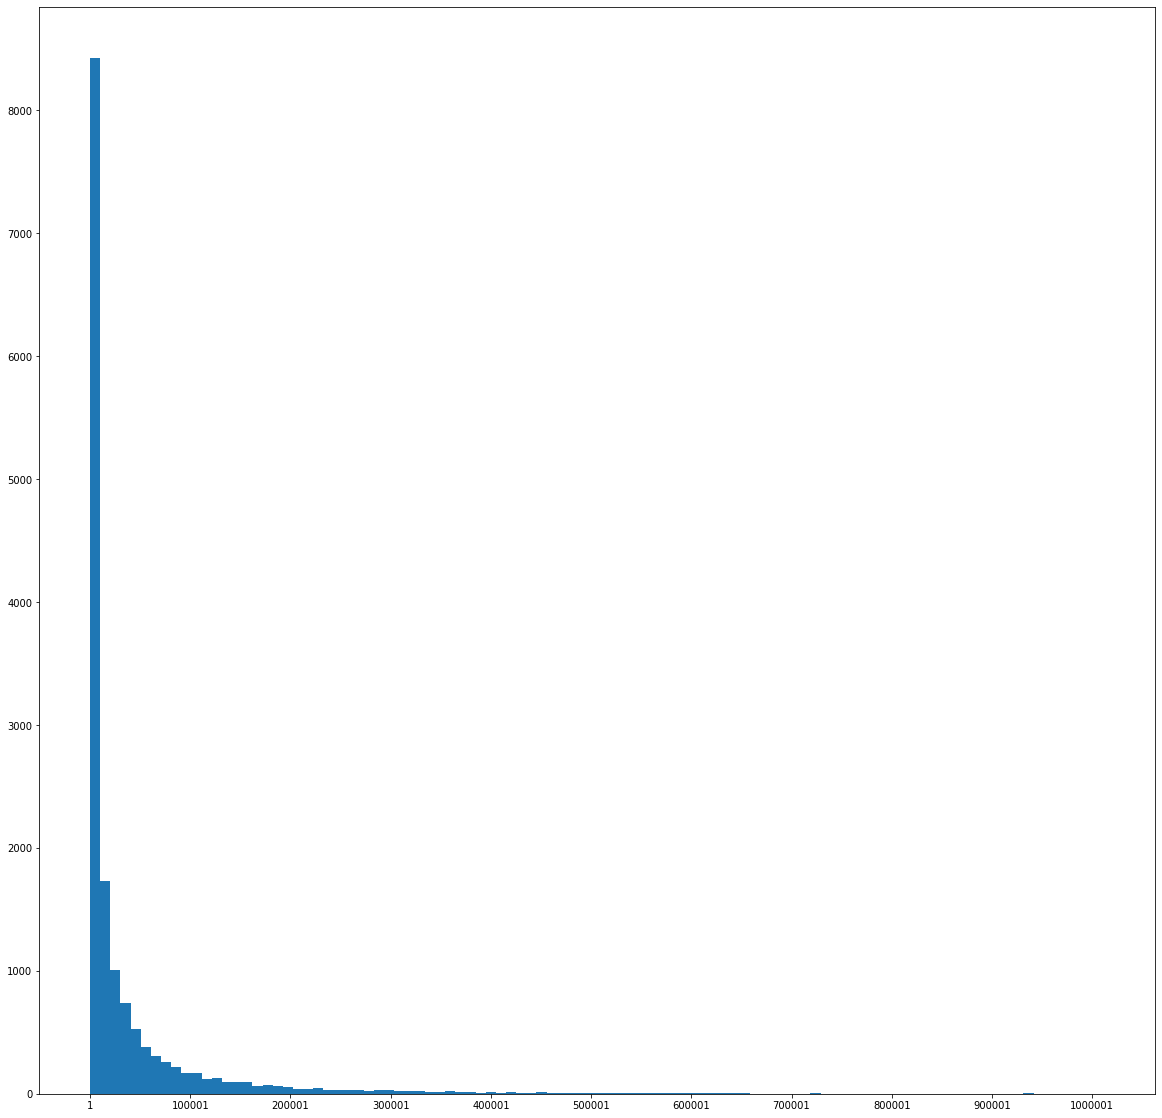

In [51]:
plt.figure(figsize = (20,20))
plt.hist(obj_areas, bins=100)
plt.xticks(np.arange(min(obj_areas), max(obj_areas)+1, 100000))
plt.show()

In [8]:
DatasetCatalog.register("2d_3d_semantics_area_3", lambda d='/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/': get_stanford_dicts(d, '/home/ubuntu/2D-3D-Semantics/area_3/data/area_3.json'))
MetadataCatalog.get("2d_3d_semantics_area_3").set(thing_classes=['table', 'chair', 'sofa', 'bookcase', 'board'])
stanford_metadata = MetadataCatalog.get("2d_3d_semantics_area_3")

In [9]:
stanford_metadata

Metadata(name='2d_3d_semantics_area_3', thing_classes=['table', 'chair', 'sofa', 'bookcase', 'board'])

In [11]:
cfg = get_cfg()
cfg.merge_from_file("/home/ubuntu/detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("2d_3d_semantics_area_3",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 5   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
print(trainer.train())

Config '/home/ubuntu/detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (6, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (6,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (20, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (20,) in the model! Skipped.


OrderedDict()


In [36]:
stanford_dict = get_2d_3d_semantics_dicts(imgs, class_dict)

ex
ex
ex
ex
ex
ex
ex
ex
ex
ex
ex
ex
ex
ex
ex
ex
ex
ex
ex
ex


In [18]:
sample_img = Image.open("/home/ubuntu/2D-3D-Semantics/area_3/data/rgb/camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_29_domain_rgb.png")

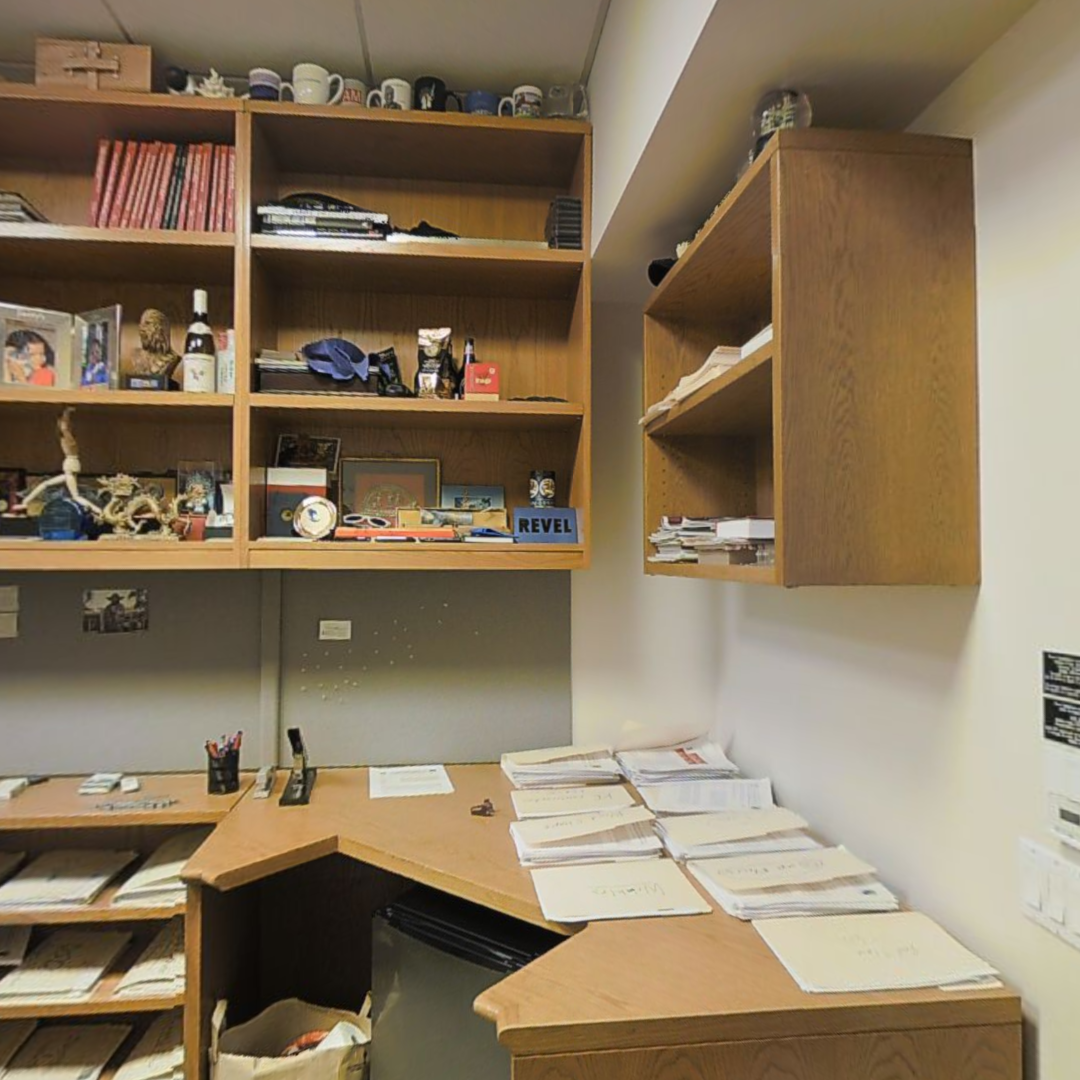

In [19]:
sample_img

In [20]:
draw = ImageDraw.Draw(sample_img)
boxes = [[0, 72, 607, 582], [640, 114, 975, 596], [0, 776, 257, 1079], [470, 347, 750, 925], [193, 835, 214, 849]]

In [21]:
for box in boxes:
    draw.rectangle(box)

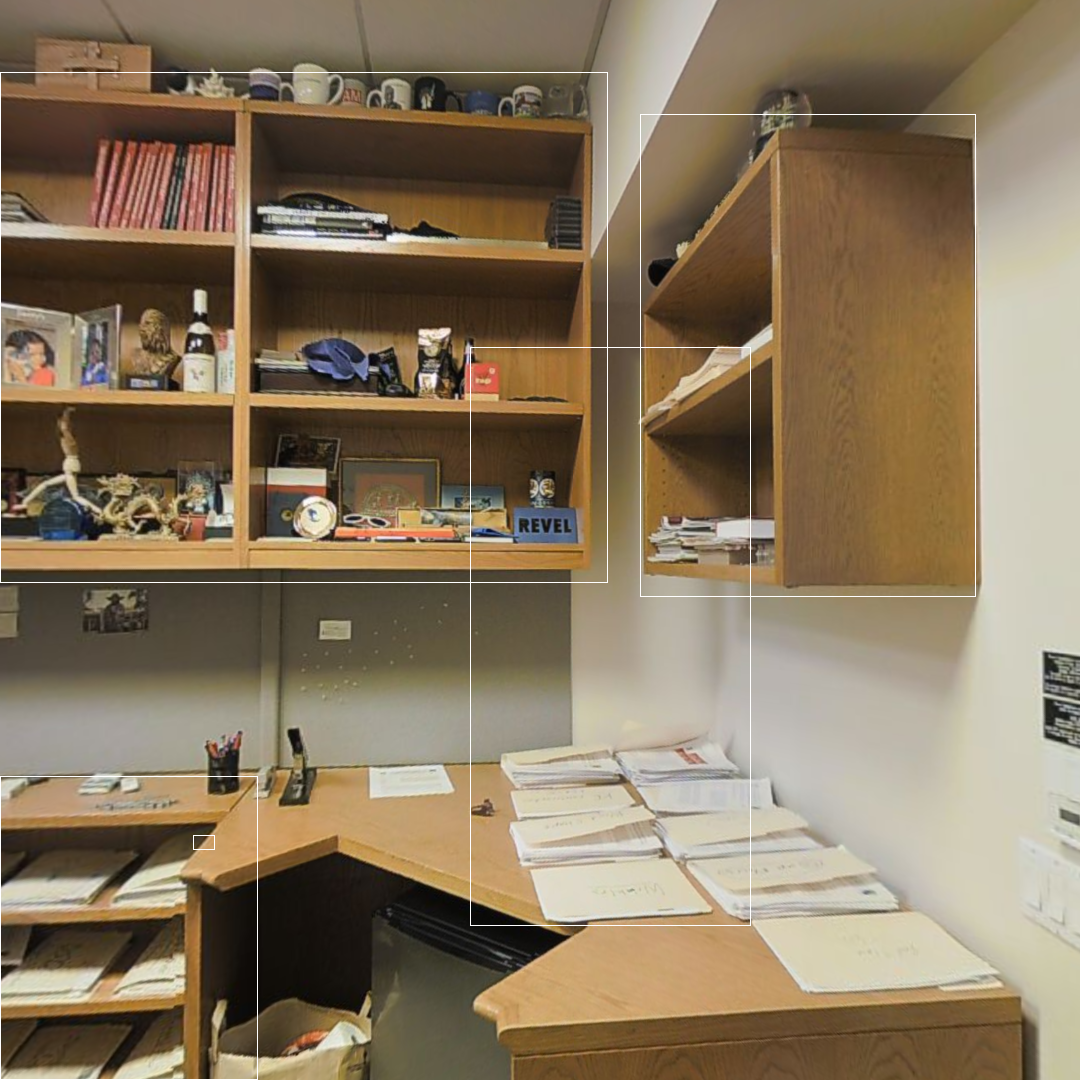

In [22]:
sample_img

In [62]:
sample_img = Image.open("/home/ubuntu/2D-3D-Semantics/area_3/data/semantic/camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_29_domain_semantic.png")

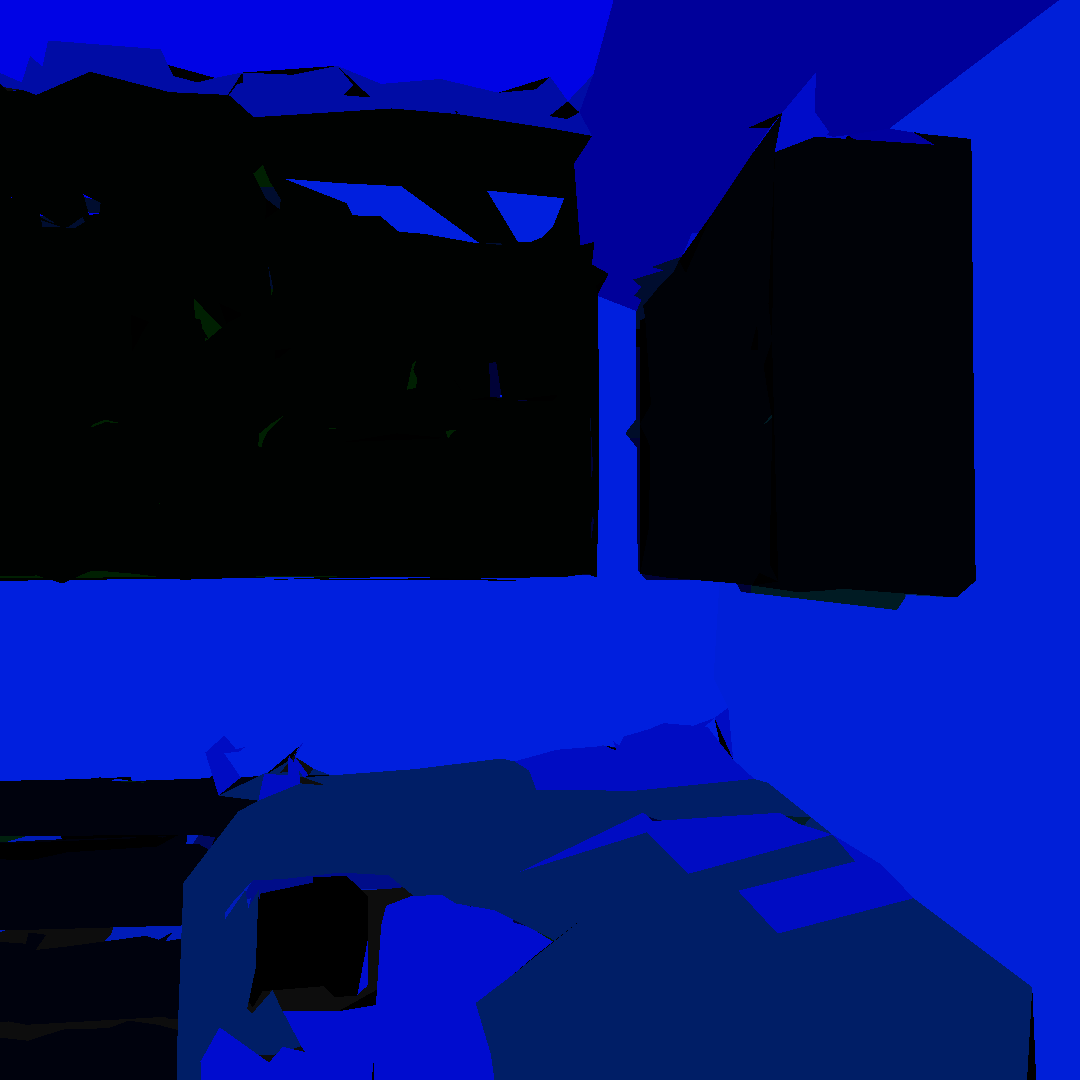

In [63]:
sample_img

In [64]:
draw = ImageDraw.Draw(sample_img)
boxes = [[0,0,50,50], [0, 72, 607, 582], [640, 114, 975, 596], [0, 776, 257, 1079], [470, 347, 750, 925], [193, 835, 214, 849]]

for box in boxes:
    draw.rectangle(box)

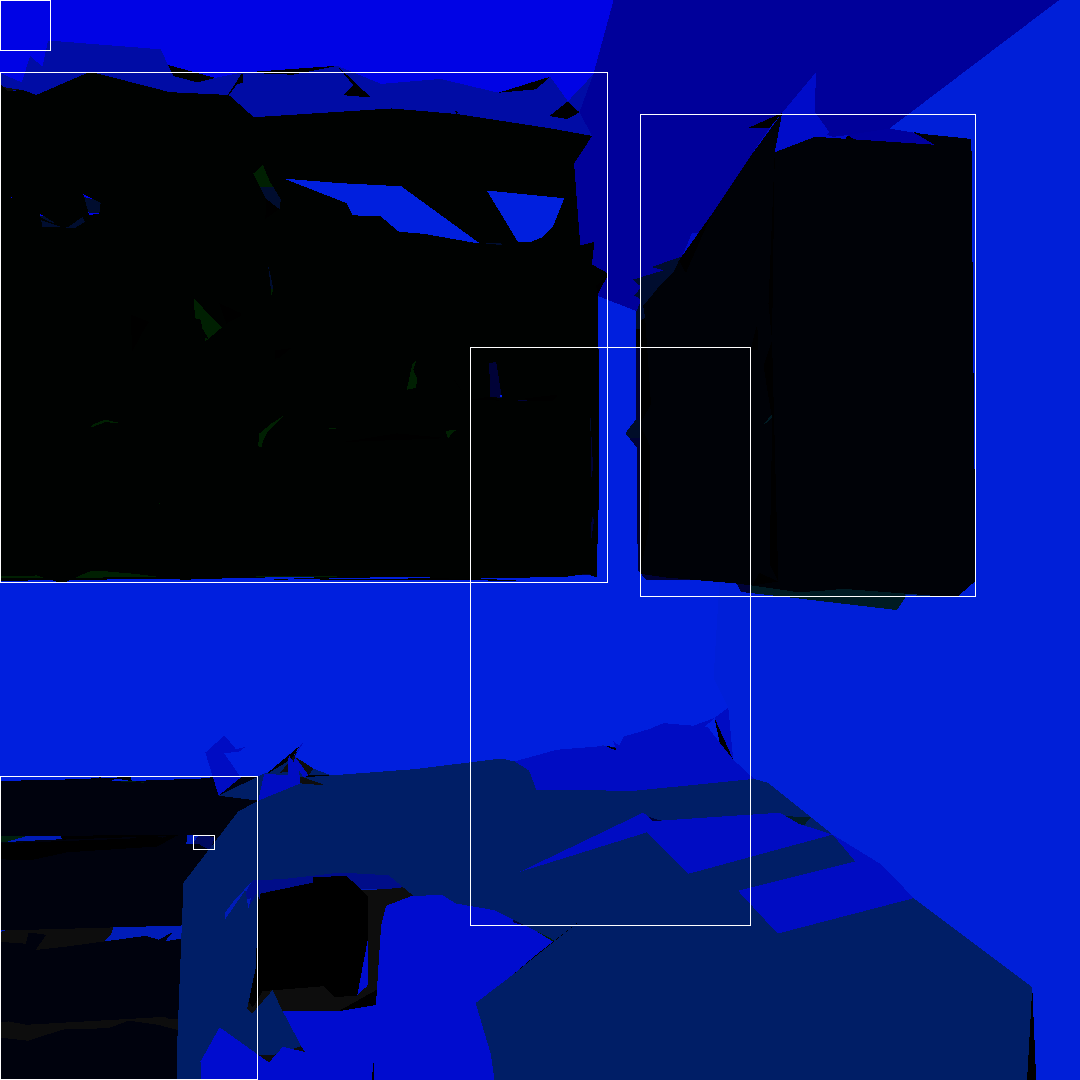

In [65]:
sample_img

In [27]:
while True:
    print('asd')

asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd
asd


KeyboardInterrupt: 

In [96]:
with open('/home/ubuntu/2D-3D-Semantics/area_3/data/area_3_fixed.json') as jsonfile:
    area_3_set = json.load(jsonfile)

In [90]:
area_3_set['camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_29_domain_rgb.png']

{'file_name': 'camera_0e30c45ea0604ddeb7467fd384362503_office_7_frame_29_domain_rgb.png',
 'height': 1080,
 'width': 1080,
 'objects': {'0': {'bbox': [0, 72, 607, 582], 'category_id': 3},
  '1': {'bbox': [640, 114, 975, 596], 'category_id': 3},
  '2': {'bbox': [0, 776, 257, 1079], 'category_id': 3},
  '3': {'bbox': [470, 347, 750, 925], 'category_id': 3},
  '4': {'bbox': [177, 759, 1031, 1079], 'category_id': 0}}}

In [97]:
area_3_set

{'camera_decc136d32514f04bb17d87af164bb3f_hallway_3_frame_7_domain_rgb.png': {'file_name': 'camera_decc136d32514f04bb17d87af164bb3f_hallway_3_frame_7_domain_rgb.png',
  'height': 1080,
  'width': 1080,
  'objects': {'0': {'bbox': [0, 623, 51, 867], 'category_id': 3},
   '1': {'bbox': [0, 827, 25, 847], 'category_id': 1}}},
 'camera_4a7bfe0577f74a1a891683cf5b435f93_lounge_1_frame_23_domain_rgb.png': {'file_name': 'camera_4a7bfe0577f74a1a891683cf5b435f93_lounge_1_frame_23_domain_rgb.png',
  'height': 1080,
  'width': 1080,
  'objects': {'0': {'bbox': [576, 653, 605, 772], 'category_id': 3},
   '1': {'bbox': [1005, 1069, 1079, 1079], 'category_id': 1},
   '2': {'bbox': [409, 714, 443, 752], 'category_id': 1},
   '3': {'bbox': [312, 713, 351, 750], 'category_id': 1},
   '4': {'bbox': [370, 718, 413, 781], 'category_id': 1},
   '5': {'bbox': [302, 734, 384, 792], 'category_id': 1},
   '6': {'bbox': [900, 830, 1079, 1077], 'category_id': 2},
   '7': {'bbox': [703, 846, 937, 1079], 'category_

In [118]:
ls

data.json  output/  output_train/  Stanford-2D-3D-detectron-set.ipynb  train.py


In [123]:
with open("/home/ubuntu/2D-3D-Semantics/area_3/data/area_3_train.json") as f:
    imgs_train = json.load(f)
    
with open("/home/ubuntu/2D-3D-Semantics/area_3/data/area_3_val.json") as f:
    imgs_val = json.load(f)
    
with open("/home/ubuntu/2D-3D-Semantics/area_3/data/area_3_test.json") as f:
    imgs_test = json.load(f)

In [127]:
len(imgs_train.keys()), len(imgs_val.keys()), len(imgs_test.keys())

(2433, 147, 165)

In [128]:
ls

data.json        output_train/            Stanford-2D-3D-detectron-set.ipynb
inference_test/  output_train_multi_set/  train.py
output/          output_train_try/


In [135]:
person = Image.open('inference_test/Object-Detection-Metrics/aux_images/table_1_v2.png')

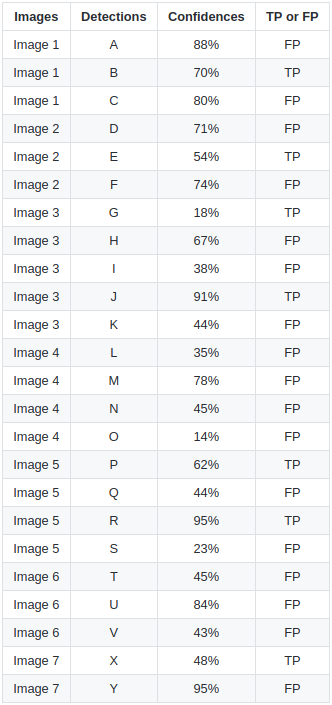

In [136]:
person

In [3]:
area_3 = glob.glob('/mnt/data/2D-3D-Semantics/area_3/data/rgb/*png')

In [10]:
area_3[7]

'/mnt/data/2D-3D-Semantics/area_3/data/rgb/camera_bbda26272dd346e595ed8e87a2d91020_office_3_frame_45_domain_rgb.png'

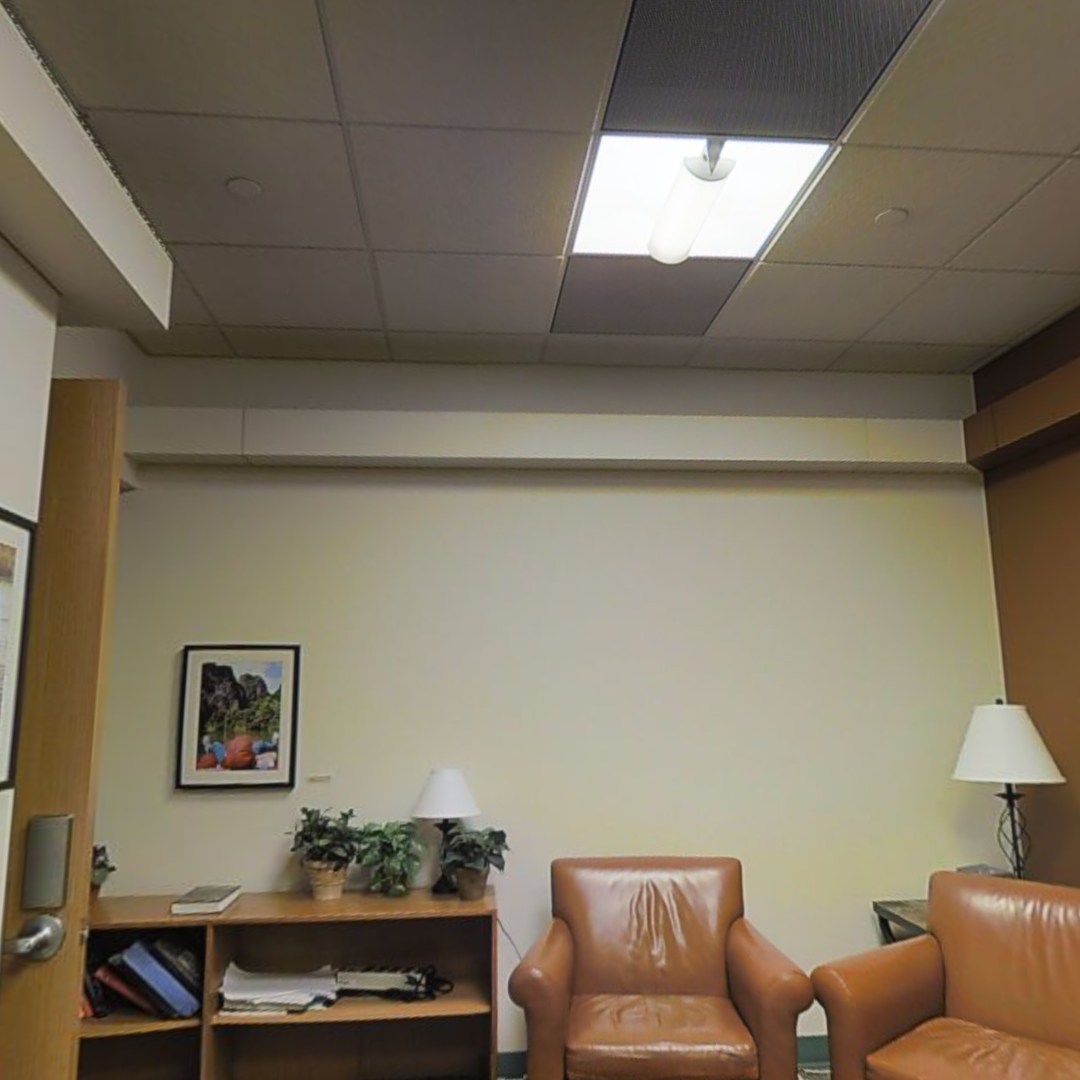

In [9]:
Image.open(area_3[7])

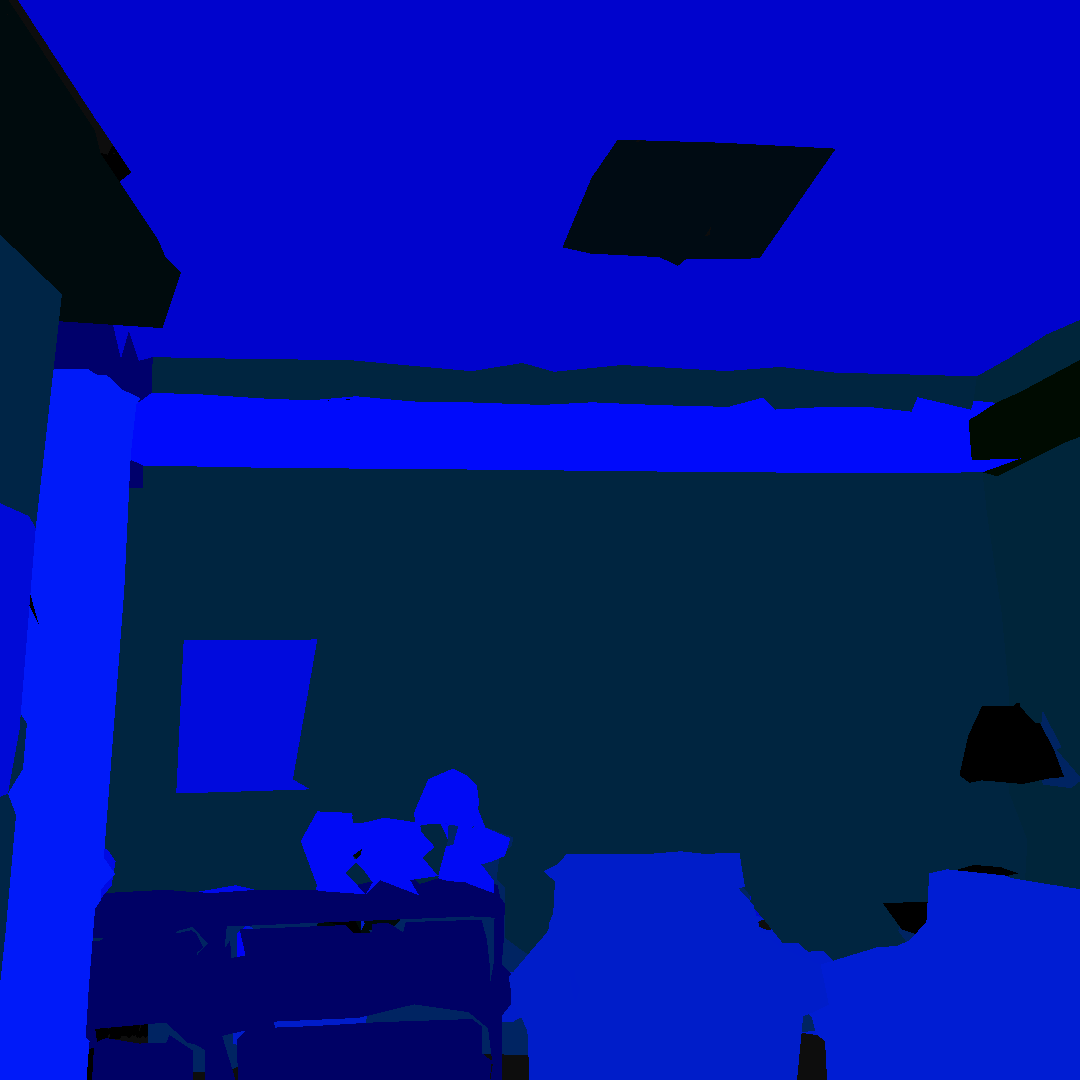

In [11]:
Image.open('/mnt/data/2D-3D-Semantics/area_3/data/semantic/camera_bbda26272dd346e595ed8e87a2d91020_office_3_frame_45_domain_semantic.png')